In [1]:
# !pip install matplotlib-venn

In [37]:
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns
import plotly.express as px
import japanize_matplotlib
import numpy as np
from datetime import datetime
import scipy.sparse as sp
from functools import partial

import random
# „É©„É≥„ÉÄ„É†„Å´ÁîüÊàê„ÅôÂÄ§„ÅÆ„Ç∑„Éº„Éâ„ÇíÂõ∫ÂÆö„Åó„Å¶ÂÜçÁèæÊÄß„ÇíÊãÖ‰øù„Åô„Çã
def seed_everything(seed:int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
sns.set_context("talk")
seed_everything(510)

from typing import List
from contextlib import contextmanager
from time import time

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD
import lightgbm as lgbm



In [3]:
# „Ç≥„Éº„Éâ„ÅÆÂÆüË°åÊôÇÈñì„ÇíË®àÊ∏¨„Åô„Çã‰æøÂà©Èñ¢Êï∞
# https://github.com/nyk510/vivid/blob/master/vivid/utils.py
class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' '):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

In [4]:
# --- 1. ÂÖ®„Éá„Éº„Çø„ÅÆË™≠„ÅøËæº„Åø ---
INPUT_DIR = "../"

In [5]:
# Âá∫Âäõ„ÅÆ„Éá„Ç£„É¨„ÇØ„Éà„É™„Çí‰ΩúÊàê
OUTPUT_DIR = "../outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [41]:
# --- 1. ÂÖ®„Éá„Éº„Çø„ÅÆË™≠„ÅøËæº„Åø ---

df_train = pd.read_csv(os.path.join(INPUT_DIR, "train.csv"))
df_test = pd.read_csv(os.path.join(INPUT_DIR, "test.csv"))
df_position = pd.read_csv(os.path.join(INPUT_DIR, "position_history.csv"))
df_overtime = pd.read_csv(os.path.join(INPUT_DIR, "overtime_work_by_month.csv"))
df_hr = pd.read_csv(os.path.join(INPUT_DIR, "hr.csv"))
df_dx = pd.read_csv(os.path.join(INPUT_DIR, "dx.csv"))
df_udemy = pd.read_csv(os.path.join(INPUT_DIR, "udemy_activity.csv"))
df_career = pd.read_csv(os.path.join(INPUT_DIR, "career.csv"), encoding='utf-8-sig')


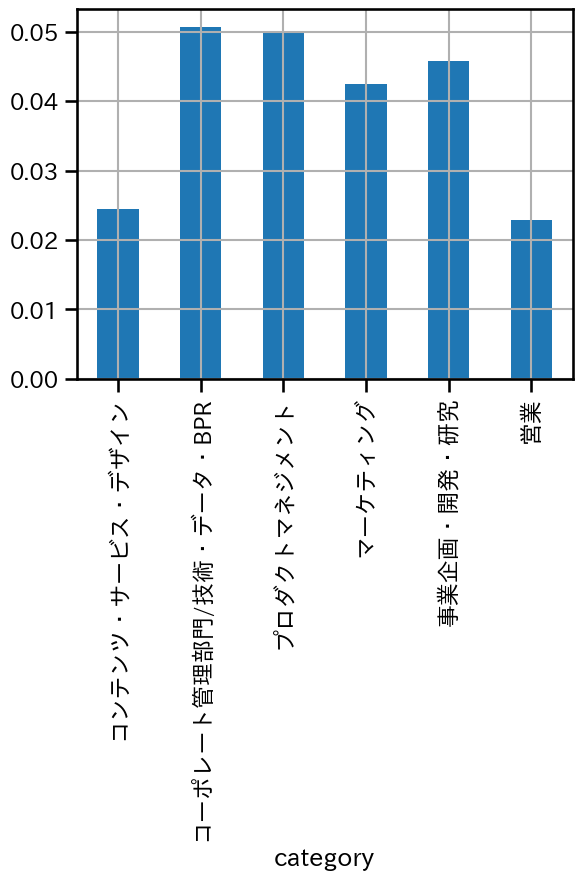

In [7]:
# ÂàùÊâã„ÅÆÂèØË¶ñÂåñ„ÅØÁõÆÁöÑÂ§âÊï∞„Åã„Çâ„ÄÇÁõÆÁöÑÂ§âÊï∞„Åå„Å©„ÅÆ„Åè„Çâ„ÅÑ„ÅÆÈ†ªÂ∫¶„ÅßÂá∫„Å¶„Åç„Å¶„ÅÑ„Çã„ÅÆ„Åã
ax = df_train.groupby("category")["target"].mean().plot(kind="bar")
ax.grid()

ÁõÆÁöÑÂ§âÊï∞„ÅÆÂèØË¶ñÂåñ„Åã„Çâ„ÄÅ„Éù„Ç∏„ÉÜ„Ç£„Éñ„Éá„Éº„Çø„ÅåÂÖ®‰Ωì„ÅÆ2ÔΩû5ÔºÖ„Å®„Å®„Å¶„ÇÇÂ∞ë„Å™„ÅÑ„Åì„Å®„ÅåÂàÜ„Åã„Çã


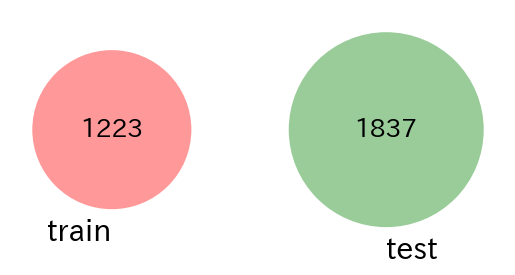

In [8]:
# „Éá„Éº„Çø„ÅÆÈáç„Å™„Çä„ÅÆÂèØË¶ñÂåñ
# train„Éá„Éº„Çø„Å®test„Éá„Éº„Çø„ÅßÁ§æÂì°„Å´Èáç„Å™„Çä„ÅåÁÑ°„ÅÑ„Åã„ÇíÁ¢∫Ë™ç
venn2(subsets=(set(df_train["Á§æÂì°Áï™Âè∑"].unique()), set(df_test["Á§æÂì°Áï™Âè∑"].unique())), set_labels=("train", "test"))

train„Éá„Éº„Çø„Å®test„Éá„Éº„Çø„ÅßÁ§æÂì°„Å´Èáç„Å™„Çä„ÅåÁÑ°„ÅÑ„Åì„Å®„ÅåÂàÜ„Åã„Çã„ÄÇ

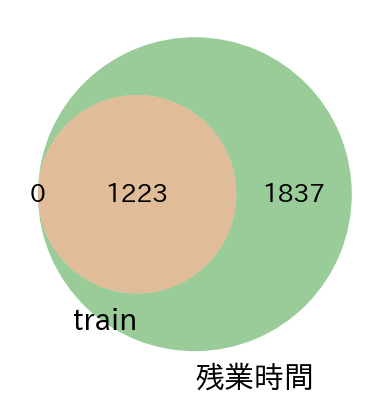

In [9]:
# ÊÆãÊ•≠ÊôÇÈñì„Åî„Å®„Å´ÂøúÂãü„Ç´„ÉÜ„Ç¥„É™„ÅÆÂøúÂãüÁéá„ÅØ„Å©„ÅÜ„Å™„Å£„Å¶„ÅÑ„Çã„ÅÆ„ÅãÔºü„Éô„É≥Âõ≥„ÇíÊõ∏„ÅÑ„Å¶„Åø„Çã
venn2(subsets=(set(df_train["Á§æÂì°Áï™Âè∑"].unique()), set(df_overtime["Á§æÂì°Áï™Âè∑"].unique())), set_labels=("train", "ÊÆãÊ•≠ÊôÇÈñì"))


ÊÆãÊ•≠ÊôÇÈñì„ÅåÁÑ°„ÅÑ„Çà„ÅÜ„Å™train„Éá„Éº„Çø„ÅØÁÑ°„ÅÑ„ÄÇ
ÊÆãÊ•≠ÊôÇÈñì„ÅÆÊ¨†Êêç„ÅåÁÑ°„ÅÑ„ÅÆ„Åß„ÄÅ„Çà„ÇäÊ©üÊ¢∞Â≠¶Áøí„Å´‰Ωø„ÅÑ„ÇÑ„Åô„ÅÑ„ÄÇ

‰ªñ„ÅÆ„Éô„É≥Âõ≥„ÇÇ‰Ωú„Å£„Å¶„Åø„Çã

C:\Users\Â†ÄÊ±üÈõÖÂΩ¶\AppData\Local\Temp\ipykernel_27408\1820460831.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  z= df_train.groupby([hours, "category"])["target"].mean().unstack()


<Axes: xlabel='category', ylabel='Á§æÂì°Áï™Âè∑'>

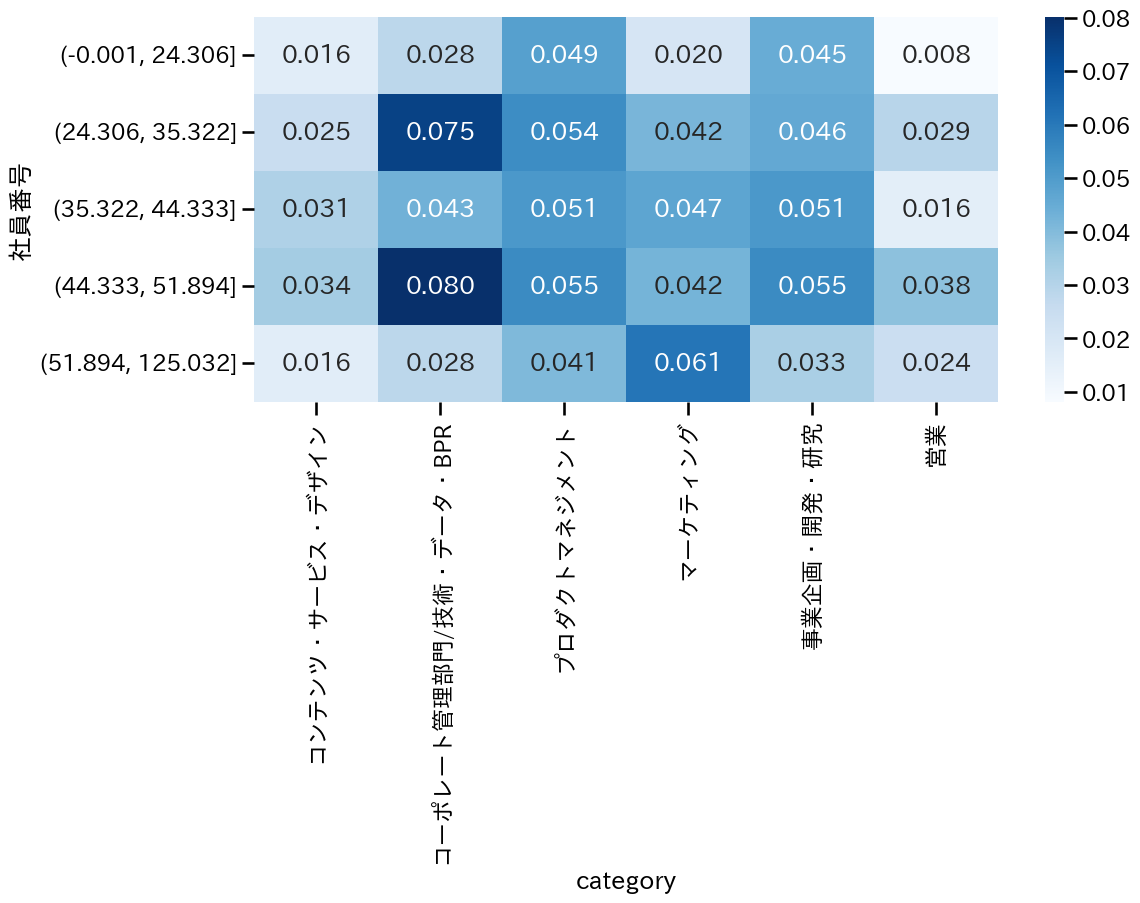

In [10]:
# Á§æÂì°„Åî„Å®„Å´Âπ≥ÂùáÊÆãÊ•≠ÊôÇÈñì„ÇíÊ±Ç„ÇÅ„Çã
mean_hours_by_workers = df_overtime.groupby("Á§æÂì°Áï™Âè∑")["hours"].mean()

# q-cut„ÅØquantile cut„ÅÆÁï•„Åß„ÄÅÈÄ£Á∂öÂú∞„ÇíÊõ∏„ÅèÂπÖ„ÅåÂêå„Åò„Åè„Çâ„ÅÑ„ÅÆ„Éá„Éº„Çø„Å´„Å™„Çã„Çà„ÅÜ„Å´Âå∫Âàá„Å£„Å¶„Åè„Çå„Çã
mean_hours_by_workers = pd.qcut(mean_hours_by_workers, q=5)
hours =df_train["Á§æÂì°Áï™Âè∑"].map(mean_hours_by_workers)

# Á∏¶Ëª∏„Åå1‰∫∫ÂΩì„Åü„Çä„ÅÆÊÆãÊ•≠ÊôÇÈñì„Å®„Å™„Çã
z= df_train.groupby([hours, "category"])["target"].mean().unstack()

fig, ax = plt.subplots(figsize=(12,5))
sns.heatmap(z, cmap="Blues", annot=True, fmt=".3f", ax=ax)

Á§æÂì°„Åî„Å®„ÅÆÊÆãÊ•≠ÊôÇÈñì„ÅÆÂèØË¶ñÂåñ„Å´„Çà„Çä„ÄÅ
„Éª„Éû„Éº„Ç±„ÉÜ„Ç£„É≥„Ç∞„ÅØÊÆãÊ•≠ÊôÇÈñì„ÅåÂ¢ó„Åà„Çã„Å®ÂÖ¨Âãü„ÅåÂ¢ó„Åà„Çã
„ÉªPdM„ÇÑ‰∫ãÊ•≠‰ºÅÁîª„ÅØÊÆãÊ•≠ÊôÇÈñì„Å´Èñ¢„Çè„Çâ„Åö„ÄÇ
„Éª„Ç≥„É≥„ÉÜ„É≥„ÉÑ„ÇÑÂñ∂Ê•≠„ÅØÁúü„Çì‰∏≠„Å´„Éî„Éº„ÇØ„Åå„ÅÇ„Çã
„Éª„Ç≥„Éº„Éù„É¨„Éº„Éà„ÅØÁúü„Çì‰∏≠„Å´„Éî„Éº„ÇØ„Åå„ÅÇ„Çã„ÄÇ
‰∏≠Á®ãÂ∫¶„ÅÆÊÆãÊ•≠ÊôÇÈñì„ÇíÊåÅ„Å£„Å¶„ÅÑ„Çã‰∫∫„ÅåÂÖ¨Âãü„Å´Êâã„Çí‰∏ä„Åí„ÇÑ„Åô„ÅÑ

ÁâπÂæ¥Èáè„Ç®„É≥„Ç∏„Éã„Ç¢„É™„É≥„Ç∞Ôºödf_position


In [11]:
# Á§æÂì°Áï™Âè∑„ÅÆÂπ¥Â∫¶„ÅÆÊúÄÂ§ß„Åã„ÇâÊúÄÂ∞è„ÇíÂºï„Åè„Å®Âú®Á±çÂπ¥Êï∞„Å´„Å™„Çã
df_position_working_years = df_position.groupby("Á§æÂì°Áï™Âè∑")["year"].max() - df_position.groupby("Á§æÂì°Áï™Âè∑")["year"].min()
print(df_position_working_years)

# Âú®Á±çÂπ¥Êï∞„Çí„ÅÇ„Çâ„Åü„Å™ÁâπÂæ¥Èáè„Å®„Åô„ÇãÈñ¢Êï∞„Çí‰ΩúÊàê
def merge_by_worker_id(left, right):
    return pd.merge(left["Á§æÂì°Áï™Âè∑"], right, on="Á§æÂì°Áï™Âè∑", how="left").drop(columns=["Á§æÂì°Áï™Âè∑"])


Á§æÂì°Áï™Âè∑
-1sqs0GXzpPJuAVKHUUFgg==    2
-2Sq3E0WkZj8pL7jxdL3Cg==    1
-4jh26kLzkU8JFQwdeQU9w==    2
-4taxxVbT1nU-J5fHWmDfQ==    2
-5W_JQCSTAYe2gGJMuT4_w==    2
                           ..
zuplFpzBoM4c1dFy5HPXqg==    2
zwcjIiu_sqUs8akLOfuYKA==    2
zxPKKLM85QljzRfp0yisow==    2
zxY0Eflwm1tYj1Wt6vo_1g==    2
zxmtr2h4ypvsNq02K9AMJg==    2
Name: year, Length: 3060, dtype: int64


In [12]:
# Á§æÂì°Áï™Âè∑„ÅÆÂΩπËÅ∑„ÅÆ„É¶„Éã„Éº„ÇØÊï∞„ÇíÊï∞„Åà„Çå„Å∞„ÄÅÂΩπËÅ∑„ÅåÂ§âÂåñ„Åó„Åü‰∫∫„Åå„ÅÑ„Çã
# 1„Å™„Çâ„Åö„Å£„Å®Âêå„ÅòÂΩπËÅ∑„ÄÇ3„Å™„ÇâÂπ¥Â∫¶„Åî„Å®„Å´ÂÖ®ÈÉ®ÈÅï„ÅÜÂΩπËÅ∑
df_position_position_count= df_position.groupby("Á§æÂì°Áï™Âè∑")["ÂΩπËÅ∑"].nunique()
print(df_position_position_count)

# ÂΩπËÅ∑„ÅÆÂ§âÂåñ„ÇíÊñ∞„Åü„Å™ÁâπÂæ¥Èáè„Å®„Åó„Å¶ËøΩÂä†
# agg„ÅØagrigation„ÅßÈõÜÁ¥ÑÊÉÖÂ†±„Å®„ÅÑ„ÅÜÊÑèÂë≥
# ÂÉç„ÅÑ„Å¶„ÅÑ„ÇãÂπ¥Êï∞„Å®„Éù„Ç∏„Ç∑„Éß„É≥„ÇíÂ§â„Åà„ÅüÂπ¥Êï∞„ÅØ‰ΩïÂõû„ÅÇ„Çã„Åã„ÇíÈõÜË®à„Åô„ÇãÈñ¢Êï∞
def create_positon_aggregation_feture(input_df):
    agg = pd.concat([
        (df_position.groupby("Á§æÂì°Áï™Âè∑")["year"].max() - df_position.groupby("Á§æÂì°Áï™Âè∑")["year"].min()),
        df_position.groupby("Á§æÂì°Áï™Âè∑")["ÂΩπËÅ∑"].nunique().rename("change_positon_count")
    ], axis=1)

    return merge_by_worker_id(input_df, agg)

create_positon_aggregation_feture(df_train)

Á§æÂì°Áï™Âè∑
-1sqs0GXzpPJuAVKHUUFgg==    2
-2Sq3E0WkZj8pL7jxdL3Cg==    1
-4jh26kLzkU8JFQwdeQU9w==    1
-4taxxVbT1nU-J5fHWmDfQ==    1
-5W_JQCSTAYe2gGJMuT4_w==    1
                           ..
zuplFpzBoM4c1dFy5HPXqg==    1
zwcjIiu_sqUs8akLOfuYKA==    2
zxPKKLM85QljzRfp0yisow==    1
zxY0Eflwm1tYj1Wt6vo_1g==    1
zxmtr2h4ypvsNq02K9AMJg==    1
Name: ÂΩπËÅ∑, Length: 3060, dtype: int64


year  change_positon_count
0        1                     1
1        1                     1
2        1                     1
3        1                     1
4        1                     1
...    ...                   ...
7333     2                     1
7334     2                     1
7335     2                     1
7336     2                     1
7337     2                     1

[7338 rows x 2 columns]

In [13]:
# ÂΩπËÅ∑„ÅÆÊúÄÁµÇÂπ¥Â∫¶„ÅÆ24Âπ¥Â∫¶„ÅÆÂΩπËÅ∑„ÅÆ„Åø„ÇíÂèñ„ÇäÂá∫„ÅôÔºàlast„Çí‰Ωø„ÅÜÔºâ
# „Ç¢„É≥„ÉÄ„Éº„Éê„Éº„ÅØ‰∏ÄÊôÇÁöÑ„Å™Â§âÊï∞„ÇíÂÆöÁæ©„Åô„Çã„Å®„Åç„Å´‰ªò„Åë„Çã„Åì„Å®„ÅåÂ§ö„ÅÑ
_df = df_position.groupby("Á§æÂì°Áï™Âè∑").last()
print(_df)
def create_career_one_hot_encoding_feature(input_df):
    column_name = "ÂΩπËÅ∑"
    unique_values = df_position[column_name].unique()
    _df = df_position.groupby("Á§æÂì°Áï™Âè∑").last()

    # ÂΩπËÅ∑„Çí„Ç´„ÉÜ„Ç¥„É™„Å´„Åô„Çã
    cat_series = pd.Categorical(_df[column_name], categories=unique_values)
    df_dummy = pd.get_dummies(cat_series, prefix=column_name)

    df_dummy.columns = df_dummy.columns.tolist()
    df_dummy["Á§æÂì°Áï™Âè∑"] = _df.index

    return merge_by_worker_id(input_df, df_dummy)



print("---„ÉØ„É≥„Éõ„ÉÉ„Éà„Ç®„É≥„Ç≥„Éº„Éá„Ç£„É≥„Ç∞ÂÆüÊñΩ---")
df_dummy = create_career_one_hot_encoding_feature(df_train)


                          year      Âã§ÂãôÂå∫ÂàÜ        ÂΩπËÅ∑
Á§æÂì°Áï™Âè∑                                              
-1sqs0GXzpPJuAVKHUUFgg==    24       Ê≠£Á§æÂì°  „Ç∞„É´„Éº„Éó„É™„Éº„ÉÄ„Éº
-2Sq3E0WkZj8pL7jxdL3Cg==    24       Ê≠£Á§æÂì°        ‰∏ÄËà¨
-4jh26kLzkU8JFQwdeQU9w==    24  Ê≠£Á§æÂì°(ÁÆ°ÁêÜËÅ∑)        Ë™≤Èï∑
-4taxxVbT1nU-J5fHWmDfQ==    24       Ê≠£Á§æÂì°        ‰∏ÄËà¨
-5W_JQCSTAYe2gGJMuT4_w==    24       Ê≠£Á§æÂì°        ‰∏ÄËà¨
...                        ...       ...       ...
zuplFpzBoM4c1dFy5HPXqg==    24       Ê≠£Á§æÂì°        ‰∏ÄËà¨
zwcjIiu_sqUs8akLOfuYKA==    24  Ê≠£Á§æÂì°(ÁÆ°ÁêÜËÅ∑)        ÈÉ®Èï∑
zxPKKLM85QljzRfp0yisow==    24       Ê≠£Á§æÂì°        ‰∏ÄËà¨
zxY0Eflwm1tYj1Wt6vo_1g==    24       Ê≠£Á§æÂì°        ‰∏ÄËà¨
zxmtr2h4ypvsNq02K9AMJg==    24       Ê≠£Á§æÂì°        ‰∏ÄËà¨

[3060 rows x 3 columns]
---„ÉØ„É≥„Éõ„ÉÉ„Éà„Ç®„É≥„Ç≥„Éº„Éá„Ç£„É≥„Ç∞ÂÆüÊñΩ---


<bound method _AxesBase.grid of <Axes: >>

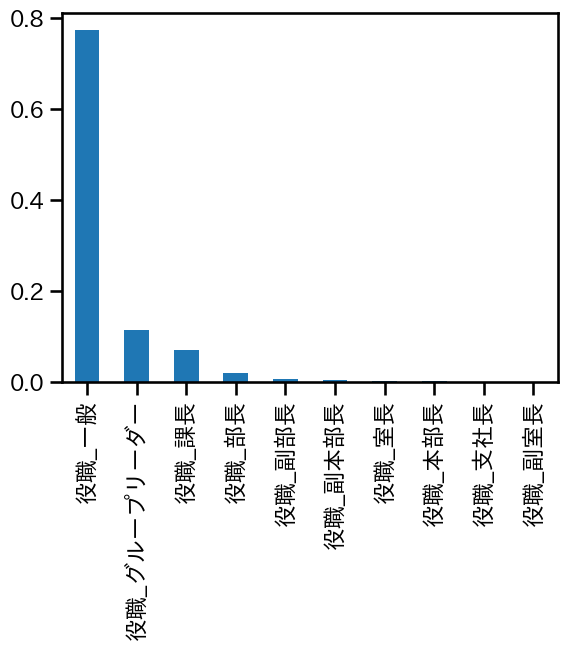

In [14]:
# „ÉØ„É≥„Éõ„ÉÉ„Éà„Ç®„É≥„Ç≥„Éº„Éá„Ç£„É≥„Ç∞Âæå„ÅÆÂàÜÂ∏É
ax = df_dummy.mean().plot(kind="bar")
ax.grid

In [15]:
# 

# „Åì„ÅÆÈñ¢Êï∞„ÅØ„ÄÅinput_df „Å®„ÅÑ„ÅÜÂêçÂâç„ÅßPandas„ÅÆ„Éá„Éº„Çø„Éï„É¨„Éº„É† (pd.DataFrame) „ÇíÂèó„ÅëÂèñ„Çä„Åæ„Åô
def create_category_one_hot_encoding_feture(input_df: pd.DataFrame):
    # Âàó„ÅÆÂêçÂâç ("category") „Çí„ÄÅcolumn_name „Å®„ÅÑ„ÅÜÂ§âÊï∞„Å´Ê†ºÁ¥ç
    column_name = "category"
    # input_df „Éá„Éº„Çø„Éï„É¨„Éº„É†„Åã„Çâ category ÂàóÔºàinput_df[column_name]Ôºâ„ÇíÂèñ„ÇäÂá∫„Åó„ÄÅ
    # .unique() „Çí‰Ωø„Å£„Å¶ÈáçË§á„Åó„Å™„ÅÑ„Ç´„ÉÜ„Ç¥„É™„ÅÆÁ®ÆÈ°û„Çí„Åô„Åπ„Å¶„É™„Çπ„Éà„Ç¢„ÉÉ„Éó
    unique_values = input_df[column_name].unique()
    # category Âàó„Çí„Ç´„ÉÜ„Ç¥„É™Âûã„Éá„Éº„Çø„Å´Â§âÊèõ„Åó„Å¶„ÅÑ„Åæ„Åô„ÄÇ
    # categories=unique_values „Å®ÊåáÂÆö„Åô„Çã„Åì„Å®„Åß„ÄÅ„Ç´„ÉÜ„Ç¥„É™„ÅÆÈ†ÜÂ∫è„Çí unique_values „ÅÆÈ†ÜÁï™„Å´Âõ∫ÂÆö
    cat_series = pd.Categorical(input_df[column_name], categories=unique_values)
    # „Ç´„ÉÜ„Ç¥„É™Âûã„ÅÆ„Éá„Éº„Çø (cat_series) „ÇíÂèó„ÅëÂèñ„Çä„ÄÅ„ÉØ„É≥„Éõ„ÉÉ„Éà„Ç®„É≥„Ç≥„Éº„Éá„Ç£„É≥„Ç∞„ÇíÂÆüË°å
    df_dummy = pd.get_dummies(cat_series, prefix=column_name)
    # „Éá„Éº„Çø„Éï„É¨„Éº„É†„ÅÆÂàóÂêçÔºàdf_dummy.columnsÔºâ„Çí‰∏ÄÂ∫¶„É™„Çπ„ÉàÂΩ¢Âºè„Å´Â§âÊèõ„Åó„ÄÅ
    # „Åù„Çå„ÇíÂÜçÂ∫¶ÂàóÂêç„Å®„Åó„Å¶Ë®≠ÂÆö„ÅóÁõ¥„Åó„Å¶„ÅÑ„Åæ„Åô„ÄÇÂøÖÈ†à„Åß„ÅØ„ÅÇ„Çä„Åæ„Åõ„Çì„ÄÇ
    df_dummy.columns = df_dummy.columns.tolist()
    
    return df_dummy

create_category_one_hot_encoding_feture(df_train)

category_„Ç≥„É≥„ÉÜ„É≥„ÉÑ„Éª„Çµ„Éº„Éì„Çπ„Éª„Éá„Ç∂„Ç§„É≥  category_„Ç≥„Éº„Éù„É¨„Éº„ÉàÁÆ°ÁêÜÈÉ®ÈñÄ/ÊäÄË°ì„Éª„Éá„Éº„Çø„ÉªBPR  \
0                         True                           False   
1                        False                            True   
2                        False                           False   
3                        False                           False   
4                        False                           False   
...                        ...                             ...   
7333                     False                            True   
7334                     False                           False   
7335                     False                           False   
7336                     False                           False   
7337                     False                           False   

      category_„Éó„É≠„ÉÄ„ÇØ„Éà„Éû„Éç„Ç∏„É°„É≥„Éà  category_„Éû„Éº„Ç±„ÉÜ„Ç£„É≥„Ç∞  category_‰∫ãÊ•≠‰ºÅÁîª„ÉªÈñãÁô∫„ÉªÁ†îÁ©∂  category_Âñ∂Ê•≠  
0                    False             False                False        False  
1                    False             False                False        False  
2                     True             False                False        False  
3                    False              True                False        False  
4                    False             False                 True        False  
...                    ...               ...                  ...          ...  
7333                 False             False                False        False  
7334                  True             False                False        False  
7335                 False              True                False        False  
7336                 False             False                 True        False  
7337                 False             False                False         True  

[7338 rows x 6 columns]

In [44]:
# career.csv„ÅÆÂä†Â∑•
import re

# „Éá„Éº„Çø„ÅÆË™≠„ÅøËæº„Åø
df_career = pd.read_csv(os.path.join(INPUT_DIR, "career.csv"), encoding='utf-8-sig')

# ÂõûÁ≠î„ÅÆÊñáÂ≠óÂàó„Åã„ÇâÂÖàÈ†≠„ÅÆÊï∞Â≠ó„ÇíÊäΩÂá∫„Åô„ÇãÈñ¢Êï∞
def extract_score(value):
    # ÂÄ§„ÅåÊñáÂ≠óÂàó„Åß„Å™„ÅÑÂ†¥ÂêàÔºà‰æã: Á©∫ÁôΩÔºâ„ÇÇËÄÉÊÖÆ
    if not isinstance(value, str):
        return np.nan
    
    # Ê≠£Ë¶èË°®Áèæ„ÅßÊñáÂ≠óÂàó„ÅÆÂÖàÈ†≠„Å´„ÅÇ„ÇãÊï∞Â≠óÔºà\dÔºâ„ÇíÊ§úÁ¥¢
    match = re.search(r'^\d', value.strip())
    
    if match:
        # Êï∞Â≠ó„ÅåË¶ã„Å§„Åã„Å£„ÅüÂ†¥Âêà„ÄÅÊï¥Êï∞„Å´Â§âÊèõ„Åó„Å¶Ëøî„Åô
        return int(match.group(0))
    else:
        # Êï∞Â≠ó„ÅåË¶ã„Å§„Åã„Çâ„Å™„ÅÑÂ†¥Âêà„ÅØNaNÔºàÊ¨†ÊêçÂÄ§Ôºâ„ÇíËøî„Åô
        return np.nan

# Á§æÂì°Áï™Âè∑‰ª•Â§ñ„ÅÆ„Åô„Åπ„Å¶„ÅÆÂàó„Å´Èñ¢Êï∞„ÇíÈÅ©Áî®
# df_career.columns[1:] „ÅØ„Äå1ÂàóÁõÆ‰ª•Èôç„ÅÆ„Åô„Åπ„Å¶„ÅÆÂàó„Äç„Å®„ÅÑ„ÅÜÊÑèÂë≥
for col in df_career.columns[1:]:
    df_career[col] = df_career[col].apply(extract_score)

# „Çπ„Ç≥„Ç¢„ÇíÂèçËª¢„Åï„Åõ„Çã„Ç´„É©„É†„ÅÆ„É™„Çπ„Éà
reverse_cols = [
    "Ëá™ÂàÜ„ÅÆ„Åì„Çå„Åã„Çâ„ÅÆ„Ç≠„É£„É™„Ç¢„Å´„ÅØ„ÄÅ„ÅÇ„Åæ„ÇäÈñ¢ÂøÉ„Åå„Å™„ÅÑ\n",
    "„Åì„Çå„Åã„Çâ„ÅÆ„Ç≠„É£„É™„Ç¢„Çí„Å©„ÅÜÊ≠©„ÇÄ„Åπ„Åç„Åã„ÄÅ„ÅÇ„Åæ„ÇäËÄÉ„Åà„Å¶„ÅÑ„Å™„ÅÑ\n",
    "Á¥çÂæó„ÅÑ„Åè„Ç≠„É£„É™„Ç¢„ÇíÊ≠©„ÇÅ„Å™„ÅÑÂéüÂõ†„ÅÆÂ§ßÂçä„ÅØÂë®Âõ≤„ÅÆÁí∞Â¢É„Å´„ÅÇ„Çã\n",
    "„Ç≠„É£„É™„Ç¢„ÅØÂë®„Çä„ÅÆÁí∞Â¢É„Å´„Çà„Å£„Å¶Ê±∫„ÇÅ„Çâ„Çå„Å¶„ÅÑ„Åè„ÇÇ„ÅÆ„Å†„Å®ÊÄù„ÅÜ\n"
]

# „Ç´„É©„É†Âêç„Å´ÊîπË°åÊñáÂ≠ó„ÅåÂê´„Åæ„Çå„Å¶„ÅÑ„Çã„Å®Ë°®Á§∫„ÅåÂ¥©„Çå„Çã„Åì„Å®„Åå„ÅÇ„Çã„Åü„ÇÅ„ÄÅ
# Ë°®Á§∫Áî®„Å´ÊîπË°å„ÇíÂâäÈô§„Åó„Åü„Ç´„É©„É†Âêç„ÅÆ„É™„Çπ„Éà„Çí‰ΩúÊàê
display_cols = [col.strip() for col in reverse_cols]
# ÂÖÉ„ÅÆ„Éá„Éº„Çø„Éï„É¨„Éº„É†„ÅÆ„Ç´„É©„É†Âêç„ÇÇ‰∏ÄÊôÇÁöÑ„Å´‰øÆÊ≠£
df_career.columns = [col.strip() if col in reverse_cols else col for col in df_career.columns]


print("--- üî¢ „Çπ„Ç≥„Ç¢ÂèçËª¢Ââç„ÅÆ„Éá„Éº„Çø ---")
print(df_career[display_cols].head())

# ÂØæË±°„Å®„Å™„ÇãÂêÑ„Ç´„É©„É†„ÅÆ„Çπ„Ç≥„Ç¢„ÇíÂèçËª¢„Åï„Åõ„Çã
for col in reverse_cols:
    if col in df_career.columns:
        df_career[col] = 6 - df_career[col]
    else:
        print(f"Ë≠¶Âëä: „Ç´„É©„É† '{col.strip()}' „ÅåË¶ã„Å§„Åã„Çä„Åæ„Åõ„Çì„Åß„Åó„Åü„ÄÇ")

print("\n" + "="*50 + "\n")

print("--- üîÑ „Çπ„Ç≥„Ç¢ÂèçËª¢Âæå„ÅÆ„Éá„Éº„Çø ---")
print(df_career[display_cols].head())

# Âá¶ÁêÜÂæå„ÅÆ„Éá„Éº„Çø„ÇíÁ¢∫Ë™ç
print("--- ÂÖ®„Å¶„ÅÆÂá¶ÁêÜ„ÅåÂÆå‰∫Ü„Åó„ÅüÂæå„ÅÆ„Éá„Éº„Çø ---")
print(df_career.head())



--- üî¢ „Çπ„Ç≥„Ç¢ÂèçËª¢Ââç„ÅÆ„Éá„Éº„Çø ---
   Ëá™ÂàÜ„ÅÆ„Åì„Çå„Åã„Çâ„ÅÆ„Ç≠„É£„É™„Ç¢„Å´„ÅØ„ÄÅ„ÅÇ„Åæ„ÇäÈñ¢ÂøÉ„Åå„Å™„ÅÑ  „Åì„Çå„Åã„Çâ„ÅÆ„Ç≠„É£„É™„Ç¢„Çí„Å©„ÅÜÊ≠©„ÇÄ„Åπ„Åç„Åã„ÄÅ„ÅÇ„Åæ„ÇäËÄÉ„Åà„Å¶„ÅÑ„Å™„ÅÑ  \
0                        4                            3   
1                        1                            1   
2                        1                            1   
3                        5                            1   
4                        2                            2   

   Á¥çÂæó„ÅÑ„Åè„Ç≠„É£„É™„Ç¢„ÇíÊ≠©„ÇÅ„Å™„ÅÑÂéüÂõ†„ÅÆÂ§ßÂçä„ÅØÂë®Âõ≤„ÅÆÁí∞Â¢É„Å´„ÅÇ„Çã  „Ç≠„É£„É™„Ç¢„ÅØÂë®„Çä„ÅÆÁí∞Â¢É„Å´„Çà„Å£„Å¶Ê±∫„ÇÅ„Çâ„Çå„Å¶„ÅÑ„Åè„ÇÇ„ÅÆ„Å†„Å®ÊÄù„ÅÜ  
0                            3                            5  
1                            1                            1  
2                            1                            1  
3                            1                            1  
4                            1                            2  
Ë≠¶Âëä: „Ç´„É©„É† 'Ëá

ÁâπÂæ¥Èáè„Ç®„É≥„Ç∏„Éã„Ç¢„É™„É≥„Ç∞„ÇíÂÆüÊñΩ„Åó„Åü„Éá„Éº„Çø„Éï„É¨„Éº„É†„ÇíÁµêÂêà„Åô„Çã

In [19]:

def build_feature(input_df: pd.DataFrame, feature_functions: List) -> pd.DataFrame:
    # „Ç´„É©„ÅÆ„Éá„Éº„Çø„Éï„É¨„Éº„É†„ÇíÁî®ÊÑè
    out_df = pd.DataFrame()
    print("start build feature...")


    # ÂêÑÁâπÂæ¥ÁîüÊàêÈñ¢Êï∞‰∫ã„Åß
    for func in feature_functions:

        with Timer(prefix=f"create {func.__name__}"):
            # ÁâπÂæ¥Èáè„Çí‰ΩúÊàê
            _df = func(input_df)

        # Ê®™ÊñπÂêëaxis=1„ÅßÁµêÂêà
        out_df = pd.concat([out_df, _df], axis=1)
    return out_df

In [20]:
# ‰ΩúÊàê„Åó„ÅüÁâπÂæ¥Èáè„Çífunctions„Å´„Åæ„Å®„ÇÅ„Çã
functions = [
    create_career_one_hot_encoding_feature,
    create_positon_aggregation_feture,
    create_category_one_hot_encoding_feture,
]

In [21]:
# functions„Çí„Åå„Å£„Å°„ÇÉ„Çì„Åì„Åô„Çã
with Timer(prefix="build train..."):
    df_train_feat = build_feature(df_train, feature_functions=functions)

with Timer(prefix="build test..."):
    df_test_feat = build_feature(df_test, feature_functions=functions)


start build feature...
create create_career_one_hot_encoding_feature 0.041[s]
create create_positon_aggregation_feture 0.046[s]
create create_category_one_hot_encoding_feture 0.006[s]
build train... 0.098[s]
start build feature...
create create_career_one_hot_encoding_feature 0.039[s]
create create_positon_aggregation_feture 0.038[s]
create create_category_one_hot_encoding_feture 0.010[s]
build test... 0.090[s]


In [22]:
# train„Å®test„ÅÆ„Ç´„É©„É†„ÅåÂÆåÂÖ®„Å´‰∏ÄËá¥„Åó„Å¶„ÅÑ„Çã„Åì„Å®„ÇíÁ¢∫Ë™ç„Åô„Çã„ÄÇÂàóÊï∞„Åå„Åö„Çå„Å¶„ÅÑ„Åü„ÇâÂàÜ„Åã„Çã„Çà„ÅÜ„Å´„Å™„Çã„ÄÇ
assert df_train_feat.columns.equals(df_test_feat.columns)

In [23]:
# „É¢„Éá„É´„ÅÆ‰ΩúÊàê(LightGBM)
# 
def fit_lgbm(X,
             y,
             cv,
             params: dict=None,
             verbose: int=50):
    # „Éë„É©„É°„Éº„Çø„Åå„Å™„ÅÑÊôÇ„ÅØ„ÄÅÁ©∫„ÅÆdict„ÅßÁΩÆ„ÅçÊèõ„Åà„Çã
    if params is None:
        params = {}
    
    models = []
    n_records = len(X)
    # training data „ÅÆtarget„Å®Âêå„Åò„Å†„Åë„ÅÆ„Çº„É≠ÈÖçÂàó„ÇíÁî®ÊÑè
    oof_pred = np.zeros((n_records, ), dtype=np.float32)

    for i, (idx_train, idx_valid) in enumerate(cv):
        # ‰∫§Â∑ÆÊ§úÂÆö„ÄÇcv instance„ÅßÂàÜÂâ≤„Åô„Çã
        # training„Éá„Éº„Çø„Çítrain/valid„Å´ÂàÜÂâ≤
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMClassifier(**params)

        with Timer(prefix="fit fold={}".format(i)):
            clf.fit(x_train, y_train,
                    eval_set=[(x_valid, y_valid)],
                    callbacks=[lgbm.callback.early_stopping(stopping_rounds=100),
                        lgbm.log_evaluation(period=verbose),],)

        # ‰∫àÊ∏¨Á¢∫Áéá„ÇíÂá∫Âäõ„Åó„Å¶„ÇÇ„Çâ„ÅÜ
        pred_i =clf.predict_proba(x_valid)
        # output„ÅÆÂΩ¢„ÅØsape = (n_samples, 2)„Å´„Å™„Å£„Å¶„ÅÑ„Çã„Åì„Å®„Å´Ê≥®ÊÑè„Åô„Çã
        y_pred_prob = pred_i[:, 1]

        oof_pred[idx_valid] = y_pred_prob
        models.append(clf)

        # ‰ªäÂõû„ÅÆÊåáÊ®ô„ÅÆMAE„ÅßË®àÁÆó„Åô„Çã
        score = roc_auc_score(y_valid, y_pred_prob, )
        print(f" -fold{i} - {score:.4f}")
    return oof_pred, models

# 5„Å§„ÅÆ„Éê„É™„Éá„Éº„Ç∑„Éß„É≥„Å´ÂàÜ„Åë„Å¶„ÅÑ„Çã
fold = GroupKFold(n_splits=5, )
cv = list(fold.split(df_train_feat.values, df_train["target"], groups=df_train["Á§æÂì°Áï™Âè∑"]))

In [24]:
# „Éë„É©„É°„Éº„Çø„Éº
params = {
    # ÁõÆÁöÑÈñ¢Êï∞„ÄÇ„Åì„Çå„ÅÆÊÑèÂë≥„ÅßÊúÄÂ∞ë„Å®„Å™„Çã„Çà„ÅÜ„Å™„Éë„É©„É°„Éº„Çø„Éº„ÇíÊé¢„Åô
    # ‰ªäÂõû„ÅØ0„Åæ„Åü„ÅØ1ÂïèÈ°å„Å™„ÅÆ„Åß„ÄÅ„Çà„Åè‰Ωø„Çè„Çå„Çãbinary„ÇíÂà©Áî®
    "objective": "binary",

    # Â≠¶ÁøíÁéáÔºöÂ∞è„Åï„ÅÑ„Åª„Å©Êªë„Çâ„Åã„Å™Ê±∫ÂÆöÈ†òÂüü„Åå‰Ωú„Çâ„Çå„ÄÅÊÄßËÉΩÂêë‰∏ä„Å´„Å§„Å™„Åå„Çã„ÅåÊôÇÈñì„Åå„Åã„Åã„Çã
    "learning_rate": .05,

    # Êú®„ÅÆÊúÄÂ§ßÂÄ§Ôºöearly_stopping„Å®„ÅÑ„ÅÜÊû†ÁµÑ„Åø„ÅßÊúü„ÅÆÊï∞„ÅØÂà∂Âæ°„Åï„Çå„Çã„Çà„ÅÜ„Å´„Åó„Å¶„ÅÑ„Çã„Åü„ÇÅ„ÄÅÂ§ß„Åç„ÅÑÂÄ§„ÇíÊåáÂÆö„Åó„Å¶„Åä„Åè
    "n_estimators": 1000,

    # ÁâπÂæ¥ÈáçË¶ÅÂ∫¶Ë®àÁÆó„ÅÆ„É≠„Ç∏„ÉÉ„ÇØ
    "importance_type": "gain",
    "random_state": 510,

    # „É≠„Ç∞„ÇíÂ∞ë„Å™„ÇÅ„Å´
    "verbose": -1
}


In [25]:
with Timer(prefix="training..."):
    oof, models = fit_lgbm(X=df_train_feat.values, y=df_train["target"].values, cv=cv, params=params)

# ÂÆüË°å„Åô„Çã„Å®-fold0 - 0.6156„Å™„Å©„Å®Âá∫Âäõ„Åï„Çå„Çã„ÄÇ
# ‰∫§Â∑ÆÊ§úÂÆöÊØé„ÅÆ„Çπ„Ç≥„Ç¢„ÇíÂá∫„Åô„Åì„Å®„Åå„Åß„Åç„Çã„ÄÇ

Training until validation scores don't improve for 100 rounds
[50]	valid_0's binary_logloss: 0.168244
[100]	valid_0's binary_logloss: 0.172955
Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.165598
fit fold=0 0.641[s]
 -fold0 - 0.6156
Training until validation scores don't improve for 100 rounds
[50]	valid_0's binary_logloss: 0.170901
[100]	valid_0's binary_logloss: 0.173934
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.168666
fit fold=1 0.265[s]
 -fold1 - 0.6139
Training until validation scores don't improve for 100 rounds
[50]	valid_0's binary_logloss: 0.17828
[100]	valid_0's binary_logloss: 0.179958
[150]	valid_0's binary_logloss: 0.180949
Early stopping, best iteration is:
[57]	valid_0's binary_logloss: 0.178248
fit fold=2 0.316[s]
 -fold2 - 0.6437
Training until validation scores don't improve for 100 rounds
[50]	valid_0's binary_logloss: 0.153012
[100]	valid_0's binary_logloss: 0.154191
Early stopping, best iteration is:
[33]	valid_0's bi

In [26]:
# train„Éá„Éº„Çø„ÇíÁî®„ÅÑ„Å¶„É¢„Éá„É´„ÅÆÊ§úË®º„ÇíÂÆüÊñΩ„Åô„Çã„ÄÇ
roc_auc_score(df_train["target"], oof)

0.6266777638095369

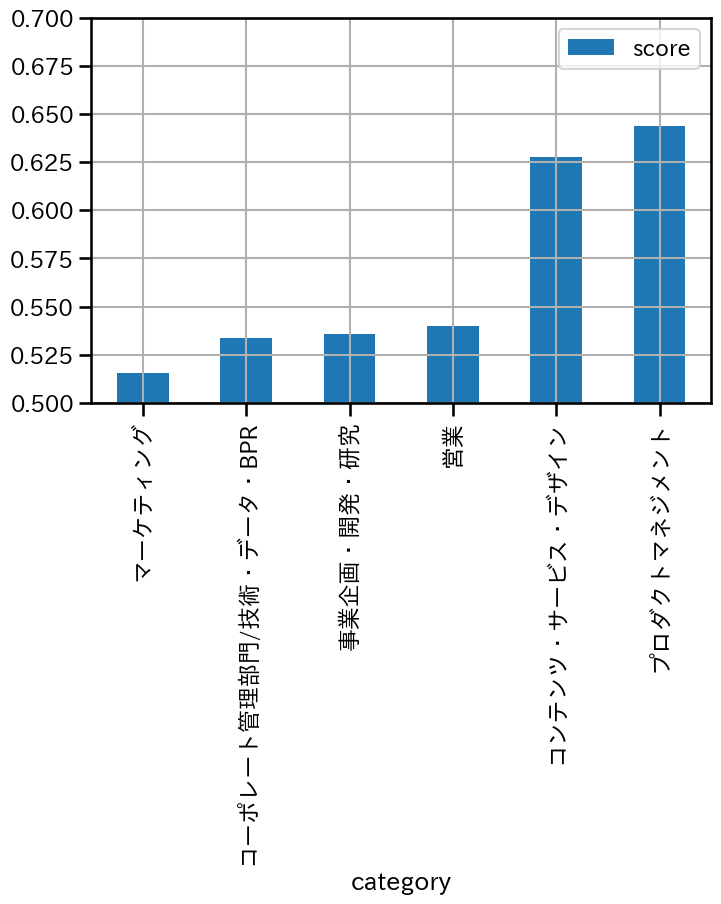

In [27]:
# Ë§áÊï∞„ÅÆ„Ç´„ÉÜ„Ç¥„É™„Åî„Å®„Å´ÂøúÂãüÊúâÁÑ°„Çí‰∫àÊ∏¨„Åó„Å™„Åè„Å¶„ÅØ„Å™„Çâ„Å™„ÅÑ
# „Å©„ÅÆ„Ç´„ÉÜ„Ç¥„É™„ÅÆ‰∫àÊ∏¨„ÅåÈõ£„Åó„Åè„Å¶„ÄÅ„Å©„ÅÆ„Ç´„ÉÜ„Ç¥„É™„ÅÆ‰∫àÊ∏¨„ÅåÁ∞°Âçò„Å™„ÅÆ„Åã„ÇíÊääÊè°„Åó„Å¶„Åä„Åè„Å®ËâØ„ÅÑ
scores = []
for cat_name, _df in df_train.groupby("category"):
    idx = _df.index
    score_i = roc_auc_score(df_train["target"].iloc[idx], oof[idx])

    scores.append({
        "category": cat_name,
        "score": score_i
    })

fig, ax = plt.subplots(figsize=(8,5))
pd.DataFrame(scores).set_index("category").sort_values("score").plot(kind="bar", ax=ax)
ax.set_ylim([.5, .7])
ax.grid()

# ÈÉ®ÁΩ≤„Åî„Å®„Å´„Å©„ÅÆ„Åè„Çâ„ÅÑ‰∫àÊ∏¨„Åå„ÅÇ„Åü„Å£„Å¶„ÅÑ„Çã„Åã„ÇíÁ¢∫Ë™ç„Åô„Çã„Åì„Å®„Åå„Åß„Åç„Çã„ÄÇ
# „Éû„Éº„Ç±„ÉÜ„Ç£„É≥„Ç∞„Çí„Å©„ÅÜ„ÇÑ„Å£„Å¶‰∫àÊ∏¨„Åß„Åç„Çã„Åã„Å™„Å©„ÇíËÄÉ„Åà„Å¶„Åø„Çã‚ÜíÊñ∞„Åü„Å™ÁâπÂæ¥Èáè„ÇíËÄÉ„Åà„Çã

C:\Users\Â†ÄÊ±üÈõÖÂΩ¶\AppData\Local\Temp\ipykernel_27408\411243715.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=feature_importance_df,


Text(0.5, 1.0, 'Feature Importance (LightGBM)')

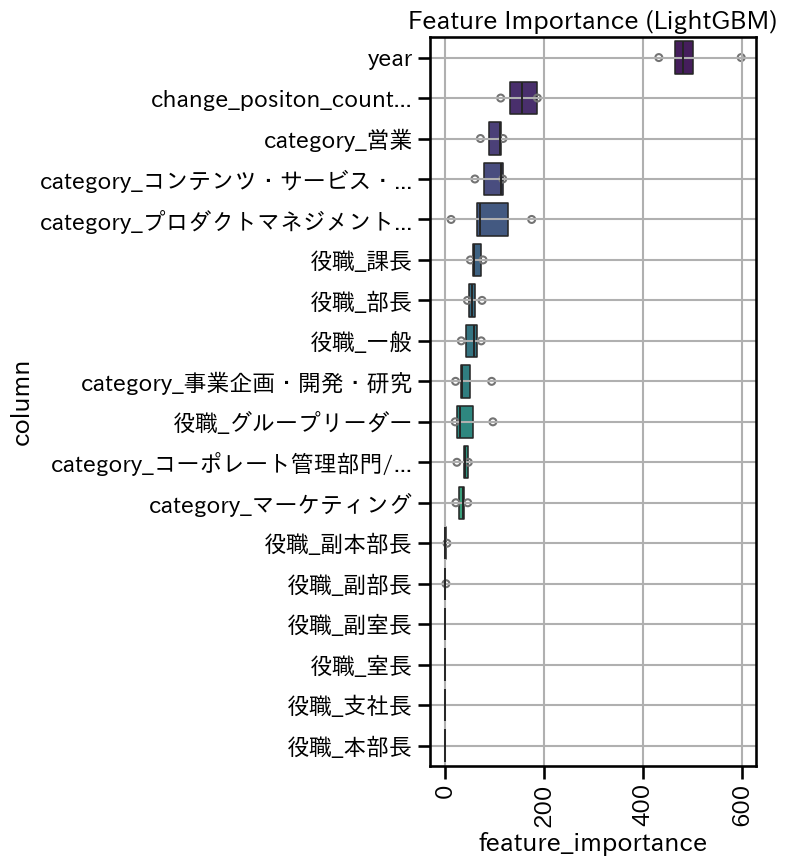

In [28]:
# ÁâπÂæ¥ÈáçË¶ÅÂ∫¶
# Â§ß‰∫ã„Å™ÁâπÂæ¥Èáè„Å®Â§ß‰∫ã„Åß„ÅØ„Å™„ÅÑÁâπÂæ¥Èáè„ÇíÊé¢„Åõ„Çã
# LightGBMÁî®„ÅÆÁâπÂæ¥ÈáèÈáçË¶ÅÂ∫¶
def visualize_importance(models, feat_train_df):
    """lightGBM „ÅÆ model ÈÖçÂàó„ÅÆ feature importance „Çí plot „Åô„Çã
    CV„Åî„Å®„ÅÆ„Éñ„É¨„Çí boxen plot „Å®„Åó„Å¶Ë°®Áèæ„Åó„Åæ„Åô.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            Â≠¶ÁøíÊôÇ„Å´‰Ωø„Å£„Åü DataFrame
    """
    feature_importance_df = pd.DataFrame(models)
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importances_

        columns = [c if len(c) < 20 else c[:20] + "..." for c in feat_train_df.columns]
        _df["column"] = columns
        _df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df],
                                          axis=0, ignore_index=True)
    order = feature_importance_df.groupby("column")\
        .sum()[["feature_importance"]]\
        .sort_values("feature_importance", ascending=False).index[:50]
    
    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .5)))
    sns.boxenplot(data=feature_importance_df,
                  x="feature_importance",
                  y="column",
                  order=order,
                  ax=ax,
                  palette="viridis",
                  orient="h"
                  )
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax

fig, ax = visualize_importance(models, df_train_feat)
ax.set_title("Feature Importance (LightGBM)")

In [ ]:
# ‰∫àÊ∏¨„Éï„Ç°„Ç§„É´„Çí‰Ωú„Çã„ÄÇ5„Åì‰∫àÊ∏¨„Éï„Ç°„Ç§„É´„Çí‰Ωú„Å£„Å¶„Åù„ÅÆÂπ≥Âùá„Åß„É¢„Éá„É´„ÅåÊßãÁØâ„Åï„Çå„Çã„ÄÇ
df_submission = pd.DataFrame()

predicts = [model.predict_proba(df_test_feat)[:, 1]for model in models]
predict_i = np.array(predicts).mean(axis=0)
df_submission["target"] = predict_i

# 1. ÁèæÂú®„ÅÆÊó•ÊôÇ„ÇíÂèñÂæó
now = datetime.now()
timestamp = now.strftime("%Y%m%d_%H%M")
filename = f"{timestamp}_submission.csv"

df_submission.to_csv(os.path.join(OUTPUT_DIR, filename),index=False)

In [ ]:
# # --- 2. ÂêÑ„Éá„Éº„Çø„ÅÆÈõÜË®à„ÉªÂä†Â∑• ---

# # ÂøúÂãüËÄÖ„Éá„Éº„ÇøÔºà„Çø„Éº„Ç≤„ÉÉ„ÉàÔºâ„ÅÆ‰ΩúÊàê
# df_target = df_train.groupby('Á§æÂì°Áï™Âè∑')['target'].max().reset_index()

# # ÊúÄÊñ∞„ÅÆÂΩπËÅ∑„Éá„Éº„Çø„ÇíÊäΩÂá∫
# df_position_latest = df_position.sort_values('year').groupby('Á§æÂì°Áï™Âè∑').last().reset_index()

# # ÊÆãÊ•≠ÊôÇÈñì„ÅÆÂπ≥Âùá„ÇíÁÆóÂá∫
# df_overtime_avg = df_overtime.groupby('Á§æÂì°Áï™Âè∑')['hours'].mean().reset_index()
# df_overtime_avg = df_overtime_avg.rename(columns={'hours': 'ÊúàÂπ≥ÂùáÊÆãÊ•≠ÊôÇÈñì'})

# # Á†î‰øÆ(hr)„ÅÆÂèóË¨õÂõûÊï∞„Çí„Ç´„Ç¶„É≥„Éà
# df_hr_count = df_hr.groupby('Á§æÂì°Áï™Âè∑').size().reset_index(name='Á†î‰øÆÂèóË¨õÂõûÊï∞')

# # DXÁ†î‰øÆ„ÅÆÂèóË¨õÂõûÊï∞„Çí„Ç´„Ç¶„É≥„Éà
# df_dx_count = df_dx.groupby('Á§æÂì°Áï™Âè∑').size().reset_index(name='DXÁ†î‰øÆÂèóË¨õÂõûÊï∞')

# # Udemy„ÅÆ„Ç¢„ÇØ„ÉÜ„Ç£„Éì„ÉÜ„Ç£Êï∞„Çí„Ç´„Ç¶„É≥„Éà
# df_udemy_count = df_udemy.groupby('Á§æÂì°Áï™Âè∑').size().reset_index(name='Udemy„Ç¢„ÇØ„ÉÜ„Ç£„Éì„ÉÜ„Ç£Êï∞')

# # „Ç≠„É£„É™„Ç¢„Ç¢„É≥„Ç±„Éº„Éà„ÅÆ„Éá„Éº„Çø„ÇíÂä†Â∑•
# # „Ç´„É©„É†Âêç„ÇíÁü≠Á∏Æ (‰æã: career_q1, career_q2...)
# original_career_columns = df_career.columns.tolist()
# new_career_columns = {col: f'career_q{i}' for i, col in enumerate(original_career_columns)}
# df_career_processed = df_career.rename(columns=new_career_columns)
# df_career_processed = df_career_processed.rename(columns={'career_q0': 'Á§æÂì°Áï™Âè∑'}) # Á§æÂì°Áï™Âè∑„ÅÆ„Ç´„É©„É†Âêç„ÅØÂÖÉ„Å´Êàª„Åô

# # ÂõûÁ≠î„ÅÆÊñáÂ≠óÂàó„Åã„Çâ„Çπ„Ç≥„Ç¢ÔºàÊï∞Â≠óÔºâ„ÇíÊäΩÂá∫„Åô„ÇãÈñ¢Êï∞
# def extract_score(value):
#     if isinstance(value, str):
#         match = re.search(r'^(\d)', value.strip())
#         if match:
#             return int(match.group(1))
#     return None # Êï∞ÂÄ§„ÅåË¶ã„Å§„Åã„Çâ„Å™„ÅÑÂ†¥Âêà„ÅØNoneÔºàÊ¨†ÊêçÂÄ§Ôºâ

# # Á§æÂì°Áï™Âè∑‰ª•Â§ñ„ÅÆÂÖ®„Ç´„É©„É†„Å´ÈÅ©Áî®
# for col in df_career_processed.columns:
#     if col != 'Á§æÂì°Áï™Âè∑':
#         df_career_processed[col] = df_career_processed[col].apply(extract_score)


